In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import pickle

import sys
sys.path.append("..")

import neuroprob as mdl
import neuroprob.utils as utils



dev = utils.pytorch.get_device()


PyTorch version: 1.10.2+cu102
Using device: cuda:0


In [3]:
mouse_ids = ['Mouse24', 'Mouse24', 'Mouse28', 'Mouse28', 'Mouse25', 'Mouse25'] # 'Mouse12'
session_ids = ['131213', '131216', '140312', '140313', '140123', '140124'] # '120806'


k = 0
mouse_id, session_id = mouse_ids[k], session_ids[k]
phase = 'wake'
datadir = '..'

data_dict = pickle.load(open(datadir+'/data/datasets/th1_{}_{}_{}.p'.format(mouse_id, session_id, phase), 'rb'))


In [8]:
data_dict['covariates']['invalid_behaviour']

{'HD': [], 'XY': [{'index': 0, 'length': 1281}]}

In [16]:
# resample
covariates = (
    data_dict['covariates']['x'], 
    data_dict['covariates']['y'], 
    np.unwrap(data_dict['covariates']['hd']), 
)
units = data_dict['neural']['units']

bin_size = 20
tbin, resamples, rc_t, (rx_t, ry_t, rhd_t,) = utils.neural.bin_data(
    bin_size, data_dict['sample_bin'], data_dict['neural']['spike_time_inds'], data_dict['use_sample_num'], 
    covariates, average_behav=True)

rhd_t = rhd_t % (2*np.pi)

r_t_spike = []
for u in range(units):
    r_t_spike.append(utils.neural.binned_to_indices(rc_t[u]))
    
print('time bin: ', tbin, ' units: ', units)

time bin:  0.001  units:  28


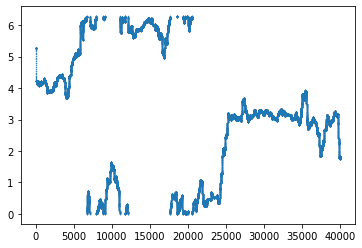

In [13]:
plt.scatter(np.arange(40000), rhd_t[:40000] % (2*np.pi), s=1, marker='.')

In [20]:
# binning of covariates and analysis
bins_hd = 60
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)

hd_rate, hd_prob = utils.neural.IPP_model(tbin, 0.0, (rhd_t,), (bin_hd,), r_t_spike, divide=True)
hd_MI = utils.neural.spike_var_MI(hd_rate, hd_prob)


filter_win = 41
centre_win = filter_win//2
sigma = 6
sfilter = np.exp(-0.5*(np.arange(filter_win)-centre_win)**2/sigma**2)
sfilter = sfilter / sfilter.sum()
sm_tun = utils.neural.smooth_hist(hd_rate, sfilter, ['periodic'], dev=dev)
coherence, sparsity = utils.neural.geometric_tuning(hd_rate, sm_tun, hd_prob)

ISI, LV = utils.neural.compute_ISI_LV(tbin, r_t_spike)

refract_viol = data_dict['neural']['refract_viol']

Mutual information $$I(x;\text{spike}) = \int p(x) \, \lambda(x) \, \log{\frac{\lambda(x)}{\langle \lambda \rangle}} \, \mathrm{d}x,$$


Local variation measure
            $$LV = 3 \langle \left( \frac{\Delta_{k-1} - \Delta_{k}}{\Delta_{k-1} + \Delta_{k}} \right)^2 \rangle$$


In [21]:
#criterion = {'refractory': 2.0, 'spatial_info': 0.5, 'sparsity': 0.2}
criterion = {'refractory': 2.0}

unit_used = []
for u in range(units):
    if ('spatial_info' in criterion and hd_MI[u] < criterion['spatial_info']) or \
       ('coherence' in criterion and coherence[u] < criterion['coherence']) or \
       ('refractory' in criterion and refract_viol[u] > criterion['refractory']) or \
       ('sparsity' in criterion and sparsity[u] < criterion['sparsity']):
        continue

    unit_used.append(u)
    
units_used = len(unit_used)
print(units_used)

28


IndexError: list index out of range

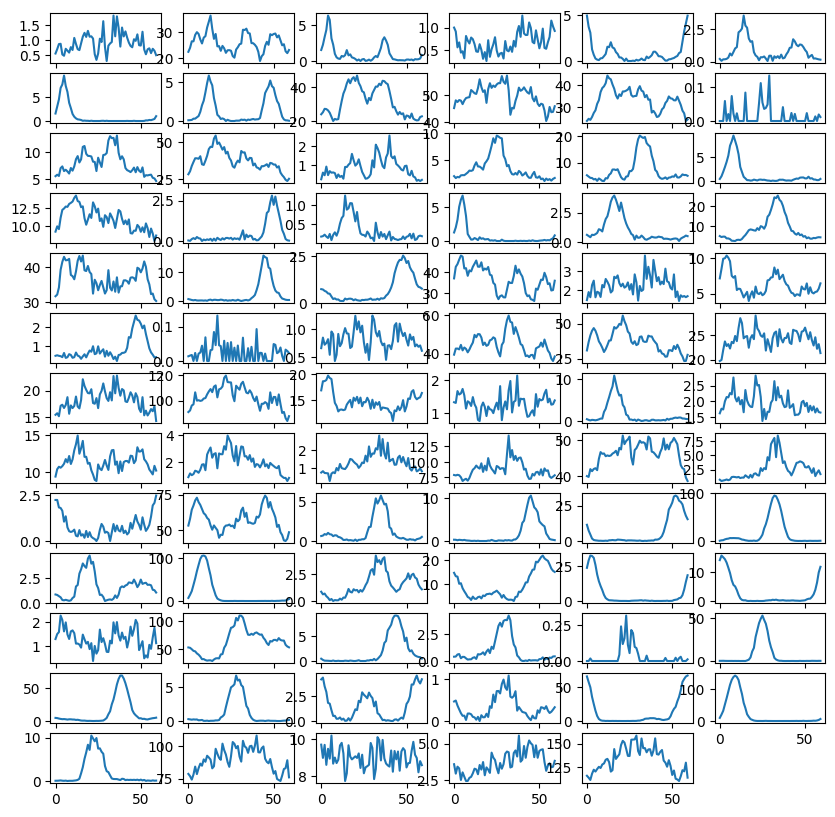

In [7]:
plt.figure(figsize=(10, 10))

for i in range(80):
    u = unit_used[i+5]
    
    plt.subplot(13, 6, i+1)
    plt.plot(hd_rate[u])

plt.show()

(60,)
(60,)
44.363783326857416


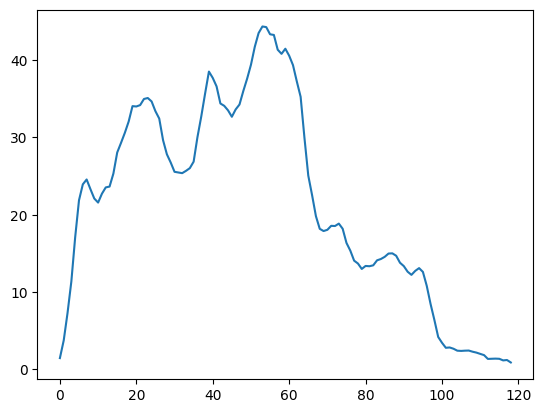

In [13]:
# compute cross correlations

# neurons to compare
ne1 = 7
ne2 = 8
print(hd_rate[ne1, :].shape)
print(hd_rate[ne2, :].shape)

correlations = np.correlate(hd_rate[ne1, :], hd_rate[ne2, :], mode='full')

fig, ax = plt.subplots()
ax.plot(correlations)
print(np.max(correlations))

In [80]:
np.array(unit_used)

array([ 7,  9, 11, 12, 20, 21, 22, 24, 26, 27, 28, 30, 31, 45, 52, 55, 56,
       57, 58, 60, 61, 62, 63, 64, 67, 68, 70, 71, 72, 73, 75, 76, 77])

In [81]:
# Mouse12 has ANT-CA1
edge = np.where(np.array(unit_used) > max(neuron_groups['ANT']))[0]
print(edge)
unit_used[20]

[]


61

In [82]:
# Mouse28 have PoS-ANT
print(np.where(np.array(unit_used) > max(neuron_groups['PoS']))[0])
print(np.where(np.array(unit_used) > max(neuron_groups['ANT']))[0])
edge = np.array([15])
print(unit_used[15])

[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[]
55


In [83]:
# remove invalid region at start
inv_ind = np.where(rx_t == -1)[0]
rx_t = rx_t[inv_ind[-1]+1:]
ry_t = ry_t[inv_ind[-1]+1:]
rhd_t = rhd_t[inv_ind[-1]+1:]
rc_t = rc_t[:, inv_ind[-1]+1:]

In [84]:
left_x = rx_t.min()
right_x = rx_t.max()
bottom_y = ry_t.min()
top_y = ry_t.max()

arena = np.array([left_x, right_x, bottom_y, top_y])

spktrain = rc_t[unit_used]

import os

if not os.path.exists('../checkpoint'):
    os.makedirs('../checkpoint')

np.savez_compressed('../checkpoint/{}_{}'.format(session_id, phase), spktrain=spktrain, 
                    arena=arena, x_t=rx_t, y_t=ry_t, hd_t=rhd_t, region_edge=edge) # edge is the start of new brain region

In [71]:
# Mouse12
left_over = np.delete(np.arange(units), unit_used)
print(np.where(left_over > max(neuron_groups['ANT'])))
print(np.where(left_over > max(neuron_groups['mPFC'])))

edge = np.array([34, 57])

(array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),)
(array([57, 58, 59, 60, 61, 62, 63]),)


In [85]:
# Mouse28
left_over = np.delete(np.arange(units), unit_used)
print(np.where(left_over > max(neuron_groups['PoS']))[0])

edge = np.array([38])

[38 39 40 41 42 43 44 45 46 47 48]


In [86]:
# leftover units
# Mouse28 have PoS-ANT
# Mouse12 has ANT-CA1

spktrain = rc_t[left_over]
np.savez_compressed('../checkpoint/{}_{}_leftover'.format(session_id, phase), spktrain=spktrain, 
                    x_t=rx_t, y_t=ry_t, hd_t=rhd_t, region_edge=edge)

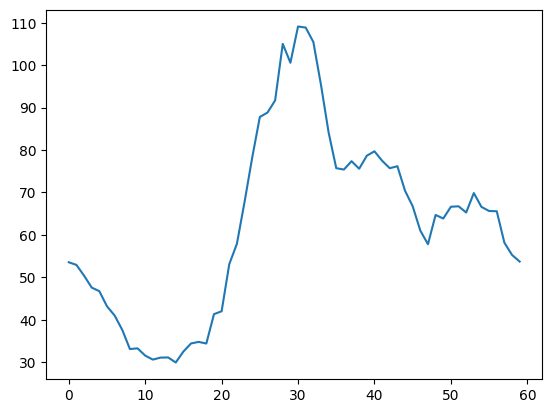

In [87]:
u = 66#left_over[8] # 8, 
plt.plot(hd_rate[u])

In [88]:
spktrain = rc_t[left_over]

In [89]:
spktrain.shape

(49, 2286282)